In [1]:
%load_ext autoreload
%autoreload 2
# -----------------------------------------------------------------------------------------------------------------------
# By Alexandra Lee
# (created Janurary 2019) 
#
# Encode Pseudomonas gene expression data into low dimensional latent space using 
# Tybalt with 2-hidden layers
# 
# Note: Need to use python 3 to support '*' syntax change
# --------------------------------------------------------------------------------------------------------------------
import os
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from functions.my_classes import DataGenerator
#from functions.vae_utils import VariationalLayer, WarmUpCallback, LossCallback
from functions.models import Tybalt

Using TensorFlow backend.


In [2]:
# To ensure reproducibility using Keras during development
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
import numpy as np
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926
randomState = 123
import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import keras
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras import metrics, optimizers
from keras.callbacks import Callback

In [3]:
# --------------------------------------------------------------------------------------------------------------------
# Initialize hyper parameters
#
# learning rate: 
# batch size: Total number of training examples present in a single batch
#             Iterations is the number of batches needed to complete one epoch
# epochs: One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE
# kappa: warmup
# original dim: dimensions of the raw data
# latent dim: dimensiosn of the latent space (fixed by the user)
#   Note: intrinsic latent space dimension unknown
# epsilon std: 
# beta: Threshold value for ReLU?
# --------------------------------------------------------------------------------------------------------------------
learning_rate_model = 0.00001
epochs_model = 100
kappa_model = 0.01

intermediate_dim_model = 100
latent_dim_model = 10
epsilon_std_model = 1.0
beta_model = K.variable(0)

chunk_size = 100

# Get dimensions of datasets
train_dim_file =  os.path.join(os.path.dirname(os.getcwd()), "metadata", "all_1M_validation_0.1", "train_dim.pickle")
val_dim_file =  os.path.join(os.path.dirname(os.getcwd()), "metadata", "all_1M_validation_0.1", "validation_dim.pickle")

with open(train_dim_file, 'rb') as f:
    num_train_samples, num_genes = pickle.load(f)
with open(val_dim_file, 'rb') as f:
    num_val_samples, num_genes = pickle.load(f)

original_dim_model = num_genes
print(num_train_samples)#num_samples_train = 1319122
print(num_val_samples)#num_samples_val = 1319

1317819
1319


In [4]:
# Load gene expression data using generator 
train_file =  "/home/alexandra/Documents/Data/LINCS_tuning/train_model_input.txt.xz"
validation_file = "/home/alexandra/Documents/Data/LINCS_tuning/validation_model_input.txt.xz"

training_generator = DataGenerator(train_file, chunk_size, num_train_samples)
validation_generator = DataGenerator(validation_file, chunk_size, num_val_samples)

In [5]:
# Model 
model = Tybalt(original_dim=original_dim_model,
                 hidden_dim=intermediate_dim_model,
                 latent_dim=latent_dim_model,
                 batch_size=chunk_size,
                 epochs=epochs_model,
                 learning_rate=learning_rate_model,
                 kappa=kappa_model,
                 beta=beta_model,
                 epsilon_std=epsilon_std_model)

In [6]:
# Output files
stat_file =  os.path.join(os.path.dirname(os.getcwd()), "stats", "tybalt_2layer_{}latent_stats.tsv".format(latent_dim_model))
hist_plot_file = os.path.join(os.path.dirname(os.getcwd()), "stats", "tybalt_2layer_{}latent_hist.png".format(latent_dim_model))

encoded_file = os.path.join(os.path.dirname(os.getcwd()), "encoded", "train_input_2layer_{}latent_encoded.txt".format(latent_dim_model))

model_encoder_file = os.path.join(os.path.dirname(os.getcwd()), "models", "tybalt_2layer_{}latent_encoder_model.h5".format(latent_dim_model))
weights_encoder_file = os.path.join(os.path.dirname(os.getcwd()), "models", "tybalt_2layer_{}latent_encoder_weights.h5".format(latent_dim_model))
model_decoder_file = os.path.join(os.path.dirname(os.getcwd()), "models", "tybalt_2layer_{}latent_decoder_model.h5".format(latent_dim_model))
weights_decoder_file = os.path.join(os.path.dirname(os.getcwd()), "models", "tybalt_2layer_{}latent_decoder_weights.h5".format(latent_dim_model))

In [7]:
# Compile Model
model.build_encoder_layer()
model.build_decoder_layer()
model.compile_vae()
model._connect_layers()
model.get_summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 978)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          97900       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100)          400         dense_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 100)          0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dense_2 (D

/home/alexandra/Documents/Repos/LINCS_latent_space/scripts/functions/models.py:86: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  self.vae.compile(optimizer=adam, loss=None, loss_weights=[self.beta])


In [8]:
# Model architecture
model_architecture_file = os.path.join(os.path.dirname(os.getcwd()),'stats', 'vae_architecture.png')
model.visualize_architecture(model_architecture_file)

In [9]:
%%time
model.train_vae(train_df=training_generator,
                test_df=validation_generator,
               separate_loss=True)

updating callback loss...
[                                           5720       466      6009      2309  \
cid                                                                            
CPC004_A375_6H_X1_B3_DUO52HI53LO:G17  0.649718  0.499203  0.809847  0.439703   
CPC004_A375_6H_X2_B3_DUO52HI53LO:G17  0.679951  0.497932  0.829780  0.404272   
CPC004_A375_6H_X3_B3_DUO52HI53LO:G17  0.683030  0.542790  0.821542  0.407817   
CPC005_A375_6H_X1_B3_DUO52HI53LO:I02  0.566242  0.298860  0.838838  0.310513   
CPC005_A375_6H_X2_B3_DUO52HI53LO:I02  0.704977  0.555760  0.808984  0.441740   
CPC005_A375_6H_X3_B3_DUO52HI53LO:I02  0.689629  0.531040  0.814176  0.395760   
CPC004_A375_6H_X1_B3_DUO52HI53LO:H23  0.655372  0.504443  0.798599  0.431877   
CPC004_A375_6H_X2_B3_DUO52HI53LO:H23  0.678231  0.495177  0.821705  0.401072   
CPC005_A375_6H_X1_B3_DUO52HI53LO:D24  0.722062  0.545593  0.869660  0.377467   
CPC005_A375_6H_X2_B3_DUO52HI53LO:D24  0.695145  0.549140  0.843391  0.405327   
CPC005_A375_

begin training
Epoch 1/100
13178/13178 [==============================] - 916s 69ms/step - loss: 14.6883 - val_loss: 35.7775
Epoch 2/100
13178/13178 [==============================] - 908s 69ms/step - loss: 11.9752 - val_loss: 17.8042
Epoch 3/100
13178/13178 [==============================] - 887s 67ms/step - loss: 11.6934 - val_loss: 15.2099
Epoch 4/100
13178/13178 [==============================] - 880s 67ms/step - loss: 11.5308 - val_loss: 15.2989
Epoch 5/100
13178/13178 [==============================] - 880s 67ms/step - loss: 11.4053 - val_loss: 15.6270
Epoch 6/100
13178/13178 [==============================] - 879s 67ms/step - loss: 11.2978 - val_loss: 15.3425
Epoch 7/100
13178/13178 [==============================] - 879s 67ms/step - loss: 11.2052 - val_loss: 14.7707
Epoch 8/100
13178/13178 [==============================] - 879s 67ms/step - loss: 11.1169 - val_loss: 13.9847
Epoch 9/100
13178/13178 [==============================] - 880s 67ms/step - loss: 11.0371 - val_loss: 13.

Epoch 28/100
13178/13178 [==============================] - 880s 67ms/step - loss: 10.0033 - val_loss: 11.3355
Epoch 29/100
13178/13178 [==============================] - 883s 67ms/step - loss: 9.9579 - val_loss: 11.2730
Epoch 30/100
13178/13178 [==============================] - 880s 67ms/step - loss: 9.9125 - val_loss: 11.2476
Epoch 31/100
13178/13178 [==============================] - 882s 67ms/step - loss: 9.8688 - val_loss: 11.1197
Epoch 32/100
13178/13178 [==============================] - 879s 67ms/step - loss: 9.8239 - val_loss: 11.1037
Epoch 33/100
13178/13178 [==============================] - 883s 67ms/step - loss: 9.7819 - val_loss: 10.9392
Epoch 34/100
13178/13178 [==============================] - 880s 67ms/step - loss: 9.7403 - val_loss: 10.8217
Epoch 35/100
13178/13178 [==============================] - 882s 67ms/step - loss: 9.6990 - val_loss: 10.7608
Epoch 36/100
13178/13178 [==============================] - 880s 67ms/step - loss: 9.6580 - val_loss: 10.7306
Epoch 37/

13178/13178 [==============================] - 878s 67ms/step - loss: 8.8691 - val_loss: 11.1185
Epoch 56/100
13178/13178 [==============================] - 879s 67ms/step - loss: 8.8315 - val_loss: 11.1852
Epoch 57/100
13178/13178 [==============================] - 880s 67ms/step - loss: 8.7937 - val_loss: 11.2287
Epoch 58/100
13178/13178 [==============================] - 880s 67ms/step - loss: 8.7593 - val_loss: 11.3310
Epoch 59/100
13178/13178 [==============================] - 879s 67ms/step - loss: 8.7256 - val_loss: 11.3598
Epoch 60/100
13178/13178 [==============================] - 878s 67ms/step - loss: 8.6911 - val_loss: 11.4031
Epoch 61/100
13178/13178 [==============================] - 878s 67ms/step - loss: 8.6595 - val_loss: 11.3995
Epoch 62/100
13178/13178 [==============================] - 877s 67ms/step - loss: 8.6270 - val_loss: 11.5464
Epoch 63/100
13178/13178 [==============================] - 880s 67ms/step - loss: 8.5952 - val_loss: 11.5649
Epoch 64/100
13178/1317

Epoch 82/100
13178/13178 [==============================] - 874s 66ms/step - loss: 8.0990 - val_loss: 11.6550
Epoch 83/100
13178/13178 [==============================] - 873s 66ms/step - loss: 8.0786 - val_loss: 11.6382
Epoch 84/100
13178/13178 [==============================] - 874s 66ms/step - loss: 8.0604 - val_loss: 11.6491
Epoch 85/100
13178/13178 [==============================] - 874s 66ms/step - loss: 8.0397 - val_loss: 11.6939
Epoch 86/100
13178/13178 [==============================] - 874s 66ms/step - loss: 8.0199 - val_loss: 11.7837
Epoch 87/100
13178/13178 [==============================] - 873s 66ms/step - loss: 8.0003 - val_loss: 11.6830
Epoch 88/100
13178/13178 [==============================] - 887s 67ms/step - loss: 7.9834 - val_loss: 11.7554
Epoch 89/100
13178/13178 [==============================] - 880s 67ms/step - loss: 7.9641 - val_loss: 11.8329
Epoch 90/100
13178/13178 [==============================] - 878s 67ms/step - loss: 7.9449 - val_loss: 11.7779
Epoch 91/1

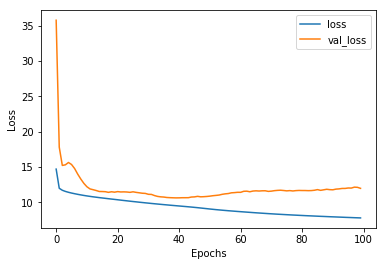

In [10]:
model_training_file = os.path.join(os.path.dirname(os.getcwd()), 'stats', 'training.pdf')
model.visualize_training(model_training_file)

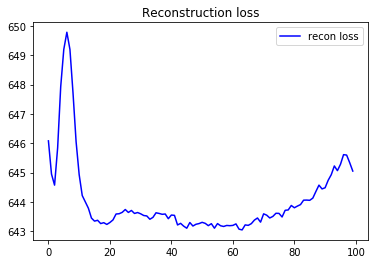

In [11]:
# Plot reconstruction loss
recon_loss = model.history_df['recon']
epochs = range(epochs_model)
plt.figure()
plt.plot(epochs, recon_loss, 'b', label='recon loss')
plt.title('Reconstruction loss')
plt.legend()
plt.show()

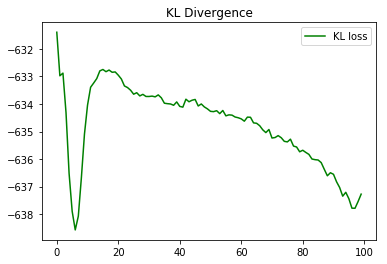

In [12]:
# Plot KL divergence
kl_loss = model.history_df['kl']
epochs = range(epochs_model)
plt.figure()
plt.plot(epochs, kl_loss, 'g', label='KL loss')
plt.title('KL Divergence')
plt.legend()
plt.show()

In [13]:
#model_compression = model.compress(training_generator)
#model_file = os.path.join(os.path.dirname(os.getcwd()), 'data', 'encoded_rnaseq_twohidden_100model.tsv.gz')
#model_compression.to_csv(model_file, sep='\t', compression='gzip')
#model_compression.head(2)

In [14]:
model_weights = model.get_decoder_weights()

In [15]:
encoder_model_file = os.path.join(os.path.dirname(os.getcwd()),'models', 'encoder_twohidden100_vae.hdf5')
decoder_model_file = os.path.join(os.path.dirname(os.getcwd()),'models', 'decoder_twohidden100_vae.hdf5')
model.save_models(encoder_model_file, decoder_model_file)